In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install torch_audiomentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [4]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:
# other dependencies
#!pip install timm ipywidgets

In [6]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [8]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [9]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [10]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [11]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [12]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 32
test_batch_size = 32
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [14]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [15]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']


### Read CSV and get train/test groups

In [16]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [17]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [18]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [19]:
len(df)

6008

In [20]:
#extracting the TZ and Cup data on which test should happen
#Test should happen on Cup and Tanzania

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [21]:
df_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


As a result of extraction ,"df_tz_cup" and "DF" doesn't have indices in sequence, let's reset.

In [22]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [23]:
df_tz_cup.head()

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


### performing a "set difference" df - df_tz_cup

In [24]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_no_tz_cup = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)
#df_temp = get_df_diff(df , df_tz_cup)


In [25]:
df_no_tz_cup

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


Verifying that the temp data does not have any test leakage

In [26]:
pd.merge(df_tz_cup,df_no_tz_cup, on = 'id',how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [27]:
df_no_tz_cup.reset_index(inplace = True)
df_no_tz_cup.drop('index',axis = 1,inplace = True)
df_no_tz_cup.drop('level_0',axis = 1,inplace = True)

In [28]:
df_no_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2


#### AT this sate "df_no_tz_cup" has no TZ and "Cup" Data . Let's verify from the length

In [29]:
print("len of df_temp = " + str(len(df_no_tz_cup)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_no_tz_cup)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training.
we'll extract 80% of TZ cup samples randomly for this purpose

In [30]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


### Again performing a "set-difference" so that:
* The final test set is a difference of entire TZ data and the ones that are sampled for the purpose of training

In [31]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [32]:
df_test
df_test.reset_index(inplace= True)

In [33]:
df_test.drop('index',axis = 1)

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,4,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,11,221144,2.56,IFA_17_28_668.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
3,16,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,19,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2531,222621,30.72,IFA_86_26_3426.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
506,2532,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
507,2534,222617,38.34,IFA_86_29_3429.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
508,2541,222604,33.28,IFA_86_36_3436.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


Add some TZ_cup sampled to the Training data

In [34]:
df_test.drop('index',axis = 1,inplace = True)
df_test.drop('level_0',axis = 1,inplace = True)

In [35]:
df_test

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,221144,2.56,IFA_17_28_668.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
3,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,222621,30.72,IFA_86_26_3426.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
506,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
507,222617,38.34,IFA_86_29_3429.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
508,222604,33.28,IFA_86_36_3436.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


We now concatenate the data extracted from TZ samples and the "DF_No_TZ_CUP" that was obtained after removing TZ and cup samples

In [36]:
temp_train_frame = [df_no_tz_cup , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


Let's now extract rows from this "Temp_frame" to get our val data


In [37]:
#df_tz_cup.sample(frac = .8 , random_state = 42)
idx_multiclass_val = np.logical_and(df_temp_train['country'] == 'Tanzania', df_temp_train['location_type'] == 'cup')
df_val = (df_temp_train[idx_multiclass_val]).sample(frac = .22 , random_state= 42)
df_val


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
706,220094,12.80,IFA_35_26_1386.wav,44100,02-03-20 00:00,mosquito,an arabiensis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2631.0
191,220600,28.10,IFA_23_33_913.wav,44100,10-02-20 00:00,mosquito,ma uniformis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,6,2088.0
453,220701,7.68,IFA_29_29_1149.wav,44100,14-02-20 00:00,mosquito,culex pipiens complex,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,2365.0
2215,222287,40.90,IFA_70_40_2800.wav,44100,21-07-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,4208.0
1204,221241,12.80,IFA_48_12_1892.wav,44100,16-06-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,220720,20.42,IFA_29_16_1136.wav,44100,14-02-20 00:00,mosquito,ma uniformis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,6,2340.0
2176,222248,35.78,IFA_70_10_2770.wav,44100,20-07-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,4168.0
1017,220405,53.76,IFA_42_25_1665.wav,44100,21-03-20 00:00,mosquito,ae aegypti,Female,f,Single,...,LC,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,2,2960.0
2189,222247,51.20,IFA_70_18_2778.wav,44100,20-07-20 00:00,mosquito,an funestus ss,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,4181.0


In [38]:
df_temp_train.reset_index(inplace = True)

In [39]:
df_val.reset_index(inplace = True)

### Now peforming a "set difference" on temp_train and df-val 

In [40]:
from sklearn.model_selection import train_test_split
# avoiding train test split and using the same logic as in original Humbug paper
# train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
#test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]
# #df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# msk = np.random.rand(len(df_temp_train)) < 0.8
# df_train = df_temp_train[msk]
# df_val_temp  = df_temp_train[~msk]
df_train = pd.concat([df_temp_train, df_val, df_val]).drop_duplicates(keep=False)


In [41]:
pd.merge(df_train,df_val , on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [42]:
df_train

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
0,0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
1,1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
2,2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
3,3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
4,4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,1531,221569,30.660000,IFA_55_32_2192.wav,44100,23-06-20 00:00,mosquito,an funestus ss,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,3503.0
5494,1214,221244,25.540000,IFA_48_19_1899.wav,44100,16-06-20 00:00,mosquito,culex pipiens complex,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,3173.0
5495,504,220949,2.560000,IFA_30_33_1193.wav,44100,17-02-20 00:00,mosquito,an arabiensis,Female,f,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2418.0
5496,2518,222601,33.280000,IFA_86_15_3415.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,4519.0


In [43]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 5049
length of val = 449


Let's verify if any of the test recording has leaked into train or val

In [44]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [45]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [46]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [47]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [48]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 108487
length of test offset = 23294
length of val offset = 20031


In [49]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [50]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [51]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [52]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [53]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.4054255  0.84995848 4.86248936 0.8756437  3.4401002  6.89594457
 4.28057923 9.63558042 0.30900846]


In [54]:
len(df_val_offset)

20031

In [55]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
29732
DF type = train
i = 1
14182
DF type = train
i = 2
2479
DF type = train
i = 3
13766
DF type = train
i = 4
3504
DF type = train
i = 5
1748
DF type = train
i = 6
2816
DF type = train
i = 7
1251
DF type = train
i = 8
39009


In [56]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
8307
DF type = Val
i = 1
3767
DF type = Val
i = 2
710
DF type = Val
i = 3
3598
DF type = Val
i = 4
829
DF type = Val
i = 5
592
DF type = Val
i = 6
570
DF type = Val
i = 7
302
DF type = Val
i = 8
1356


In [57]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [58]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [59]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [60]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [61]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [62]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [63]:
def apply_aug(x,rate):
        apply_augmentation = Compose(transforms=[AddColoredNoise(p = .5) ,TimeInversion( p = .5) ,PolarityInversion(p = .5)])
        aug_audio = apply_augmentation(x,sample_rate = rate)
        return(aug_audio)
    

class augment_audio(nn.Module):
    def __init__(self , trainable = True, sample_rate = config.rate):
        super().__init__()
        self.trainable = trainable
        self.rate = sample_rate
            
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
           
        if self.trainable:
            x = apply_aug(x , self.rate)
        else:
            x = x
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x.squeeze(dim = 1)

In [64]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [65]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2


In [66]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [67]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            overrun_counter = -1
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [68]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [69]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=apply_augmentation):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [70]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [71]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.augment_layer(x.squeeze())
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [72]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [73]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [74]:
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = apply_augmentation)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [75]:
# train_iter = iter(train_loader)
# x_temp,y_temp = train_iter.next()

In [76]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 108487
Length of train loader = 3391


In [77]:
# x_temp.shape

In [78]:
# Test block

# model_temp =Model('convnext_small',224)
# oout = model_temp(x_temp.squeeze())

## Training

In [79]:
len(df_train_offset)

108487

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0816 seconds
Training on cuda:0


  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 0batch = 0 of 3391duraation = 0.020213055610656738
epoch = 0batch = 200 of 3391duraation = 1.3613166371981302
epoch = 0batch = 400 of 3391duraation = 2.677881121635437
epoch = 0batch = 600 of 3391duraation = 3.995958451430003
epoch = 0batch = 800 of 3391duraation = 5.315470290184021
epoch = 0batch = 1000 of 3391duraation = 6.626517260074616
epoch = 0batch = 1200 of 3391duraation = 7.943002776304881
epoch = 0batch = 1400 of 3391duraation = 9.249173533916473
epoch = 0batch = 1600 of 3391duraation = 10.563178694248199
epoch = 0batch = 1800 of 3391duraation = 11.879622598489126
epoch = 0batch = 2000 of 3391duraation = 13.198400727907817
epoch = 0batch = 2200 of 3391duraation = 14.512441047032674
epoch = 0batch = 2400 of 3391duraation = 15.820594493548075
epoch = 0batch = 2600 of 3391duraation = 17.139231673876445
epoch = 0batch = 2800 of 3391duraation = 18.453015367190044
epoch = 0batch = 3000 of 3391duraation = 19.770250781377158
epoch = 0batch = 3200 of 3391duraation = 21.0911362

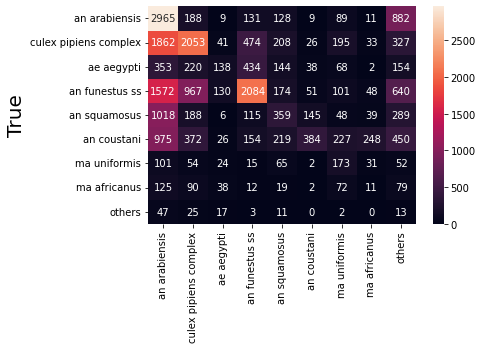

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 1batch = 0 of 3391duraation = 0.018260780970255533
epoch = 1batch = 200 of 3391duraation = 1.3407540559768676
epoch = 1batch = 400 of 3391duraation = 2.660368438561757
epoch = 1batch = 600 of 3391duraation = 3.9773831685384113
epoch = 1batch = 800 of 3391duraation = 5.294352849324544
epoch = 1batch = 1000 of 3391duraation = 6.614608534177145
epoch = 1batch = 1200 of 3391duraation = 7.935406490166982
epoch = 1batch = 1400 of 3391duraation = 9.248542523384094
epoch = 1batch = 1600 of 3391duraation = 10.57054046789805
epoch = 1batch = 1800 of 3391duraation = 11.889563000202179
epoch = 1batch = 2000 of 3391duraation = 13.203118809064229
epoch = 1batch = 2200 of 3391duraation = 14.523676606019338
epoch = 1batch = 2400 of 3391duraation = 15.844805101553598
epoch = 1batch = 2600 of 3391duraation = 17.17103048165639
epoch = 1batch = 2800 of 3391duraation = 18.4889568845431
epoch = 1batch = 3000 of 3391duraation = 19.80704549153646
epoch = 1batch = 3200 of 3391duraation = 21.12861110369

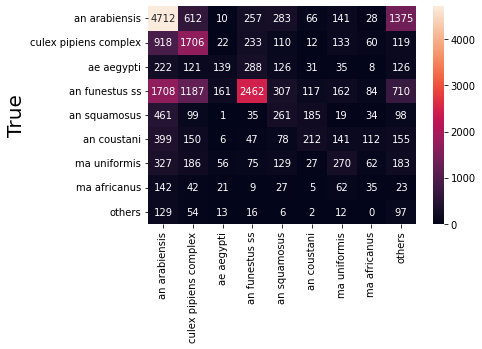

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 2batch = 0 of 3391duraation = 0.01823004086812337
epoch = 2batch = 200 of 3391duraation = 1.3566489259401957
epoch = 2batch = 400 of 3391duraation = 2.6740809281667075
epoch = 2batch = 600 of 3391duraation = 3.990575098991394
epoch = 2batch = 800 of 3391duraation = 5.319543838500977
epoch = 2batch = 1000 of 3391duraation = 6.648311738173167
epoch = 2batch = 1200 of 3391duraation = 7.972989666461944
epoch = 2batch = 1400 of 3391duraation = 9.295321838061016
epoch = 2batch = 1600 of 3391duraation = 10.615795814990998
epoch = 2batch = 1800 of 3391duraation = 11.932691450913747
epoch = 2batch = 2000 of 3391duraation = 13.254789046446483
epoch = 2batch = 2200 of 3391duraation = 14.58856576681137
epoch = 2batch = 2400 of 3391duraation = 15.905413949489594
epoch = 2batch = 2600 of 3391duraation = 17.220586017767587
epoch = 2batch = 2800 of 3391duraation = 18.54331330060959
epoch = 2batch = 3000 of 3391duraation = 19.86746554772059
epoch = 2batch = 3200 of 3391duraation = 21.1924390077

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 3batch = 0 of 3391duraation = 0.018658467133839927
epoch = 3batch = 200 of 3391duraation = 1.3473510503768922
epoch = 3batch = 400 of 3391duraation = 2.666030701001485
epoch = 3batch = 600 of 3391duraation = 3.9873030185699463
epoch = 3batch = 800 of 3391duraation = 5.298729908466339
epoch = 3batch = 1000 of 3391duraation = 6.620235657691955
epoch = 3batch = 1200 of 3391duraation = 7.940511345863342
epoch = 3batch = 1400 of 3391duraation = 9.259780077139537
epoch = 3batch = 1600 of 3391duraation = 10.5818239847819
epoch = 3batch = 1800 of 3391duraation = 11.904299624760945
epoch = 3batch = 2000 of 3391duraation = 13.223165996869405
epoch = 3batch = 2200 of 3391duraation = 14.537613546848297
epoch = 3batch = 2400 of 3391duraation = 15.867710574467976
epoch = 3batch = 2600 of 3391duraation = 17.194050220648446
epoch = 3batch = 2800 of 3391duraation = 18.505975969632466
epoch = 3batch = 3000 of 3391duraation = 19.826703222592673
epoch = 3batch = 3200 of 3391duraation = 21.15579255

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 4batch = 0 of 3391duraation = 0.02110297679901123
epoch = 4batch = 200 of 3391duraation = 1.3484627246856689
epoch = 4batch = 400 of 3391duraation = 2.6677027185757956
epoch = 4batch = 600 of 3391duraation = 3.982671813170115
epoch = 4batch = 800 of 3391duraation = 5.30485561688741
epoch = 4batch = 1000 of 3391duraation = 6.624652703603108
epoch = 4batch = 1200 of 3391duraation = 7.935080357392629
epoch = 4batch = 1400 of 3391duraation = 9.25743899345398
epoch = 4batch = 1600 of 3391duraation = 10.57819387515386
epoch = 4batch = 1800 of 3391duraation = 11.89673093954722
epoch = 4batch = 2000 of 3391duraation = 13.21071962515513
epoch = 4batch = 2200 of 3391duraation = 14.51928017536799
epoch = 4batch = 2400 of 3391duraation = 15.839032558600108
epoch = 4batch = 2600 of 3391duraation = 17.161172759532928
epoch = 4batch = 2800 of 3391duraation = 18.482994266351064
epoch = 4batch = 3000 of 3391duraation = 19.79842677513758
epoch = 4batch = 3200 of 3391duraation = 21.10767243305842

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 5batch = 0 of 3391duraation = 0.0204351544380188
epoch = 5batch = 200 of 3391duraation = 1.3349565585454306
epoch = 5batch = 400 of 3391duraation = 2.654330241680145
epoch = 5batch = 600 of 3391duraation = 3.9714834690093994
epoch = 5batch = 800 of 3391duraation = 5.284176540374756
epoch = 5batch = 1000 of 3391duraation = 6.6051716089248655
epoch = 5batch = 1200 of 3391duraation = 7.9217096646626795
epoch = 5batch = 1400 of 3391duraation = 9.237505213419597
epoch = 5batch = 1600 of 3391duraation = 10.554878099759419
epoch = 5batch = 1800 of 3391duraation = 11.868478461106617
epoch = 5batch = 2000 of 3391duraation = 13.184008745352427
epoch = 5batch = 2200 of 3391duraation = 14.504611734549204
epoch = 5batch = 2400 of 3391duraation = 15.828348763783772
epoch = 5batch = 2600 of 3391duraation = 17.1437403122584
epoch = 5batch = 2800 of 3391duraation = 18.46510728597641
epoch = 5batch = 3000 of 3391duraation = 19.786033769448597
epoch = 5batch = 3200 of 3391duraation = 21.103623930

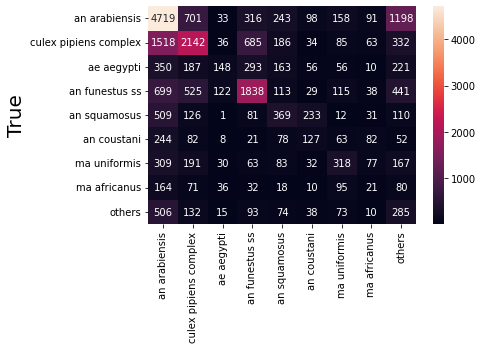

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 6batch = 0 of 3391duraation = 0.044258399804433184
epoch = 6batch = 200 of 3391duraation = 1.4631805300712586
epoch = 6batch = 400 of 3391duraation = 2.7975435217221576
epoch = 6batch = 600 of 3391duraation = 4.122777287165324
epoch = 6batch = 800 of 3391duraation = 5.453575619061788
epoch = 6batch = 1000 of 3391duraation = 6.7739453236262
epoch = 6batch = 1200 of 3391duraation = 8.09047874212265
epoch = 6batch = 1400 of 3391duraation = 9.407315357526143
epoch = 6batch = 1600 of 3391duraation = 10.718288966019948
epoch = 6batch = 1800 of 3391duraation = 12.045190358161927
epoch = 6batch = 2000 of 3391duraation = 13.362854965527852
epoch = 6batch = 2200 of 3391duraation = 14.671632933616639
epoch = 6batch = 2400 of 3391duraation = 15.989186040560405
epoch = 6batch = 2600 of 3391duraation = 17.30784387588501
epoch = 6batch = 2800 of 3391duraation = 18.621507930755616
epoch = 6batch = 3000 of 3391duraation = 19.93487658103307
epoch = 6batch = 3200 of 3391duraation = 21.25379645029

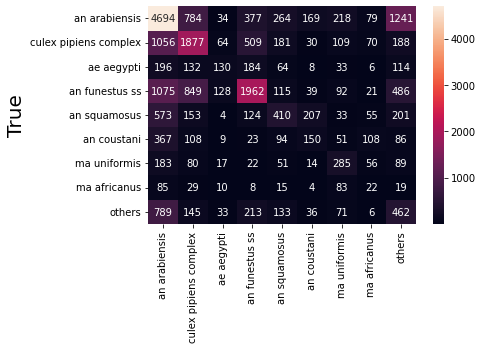

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 7batch = 0 of 3391duraation = 0.031819220383961996
epoch = 7batch = 200 of 3391duraation = 1.4082553426424662
epoch = 7batch = 400 of 3391duraation = 2.7307855049769083
epoch = 7batch = 600 of 3391duraation = 4.048080722490947
epoch = 7batch = 800 of 3391duraation = 5.358314943313599
epoch = 7batch = 1000 of 3391duraation = 6.685439685980479
epoch = 7batch = 1200 of 3391duraation = 8.002190510431925
epoch = 7batch = 1400 of 3391duraation = 9.314952905972799
epoch = 7batch = 1600 of 3391duraation = 10.625066415468853
epoch = 7batch = 1800 of 3391duraation = 11.932421926657359
epoch = 7batch = 2000 of 3391duraation = 13.251208587487538
epoch = 7batch = 2200 of 3391duraation = 14.568727453549704
epoch = 7batch = 2400 of 3391duraation = 15.87858961423238
epoch = 7batch = 2600 of 3391duraation = 17.20525629123052
epoch = 7batch = 2800 of 3391duraation = 18.51711899836858
epoch = 7batch = 3000 of 3391duraation = 19.832619945208233
epoch = 7batch = 3200 of 3391duraation = 21.163821721

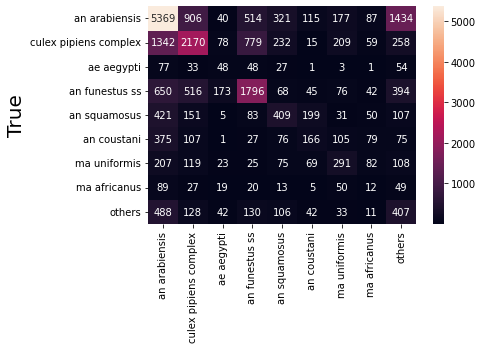

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 8batch = 0 of 3391duraation = 0.037308832009633384
epoch = 8batch = 200 of 3391duraation = 1.4211419224739075
epoch = 8batch = 400 of 3391duraation = 2.7480955004692076
epoch = 8batch = 600 of 3391duraation = 4.061761264006297
epoch = 8batch = 800 of 3391duraation = 5.388249711195628
epoch = 8batch = 1000 of 3391duraation = 6.701175173123677
epoch = 8batch = 1200 of 3391duraation = 8.023013353347778
epoch = 8batch = 1400 of 3391duraation = 9.338588730494182
epoch = 8batch = 1600 of 3391duraation = 10.656388417879741
epoch = 8batch = 1800 of 3391duraation = 11.97120240132014
epoch = 8batch = 2000 of 3391duraation = 13.291716082890828
epoch = 8batch = 2200 of 3391duraation = 14.607848834991454
epoch = 8batch = 2400 of 3391duraation = 15.921512341499328
epoch = 8batch = 2600 of 3391duraation = 17.2412659962972
epoch = 8batch = 2800 of 3391duraation = 18.55732591152191
epoch = 8batch = 3000 of 3391duraation = 19.871364267667136
epoch = 8batch = 3200 of 3391duraation = 21.1861933231

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 9batch = 0 of 3391duraation = 0.022057950496673584
epoch = 9batch = 200 of 3391duraation = 1.3693643848101298
epoch = 9batch = 400 of 3391duraation = 2.692315415541331
epoch = 9batch = 600 of 3391duraation = 4.009881365299225
epoch = 9batch = 800 of 3391duraation = 5.320457593599955
epoch = 9batch = 1000 of 3391duraation = 6.63769592444102
epoch = 9batch = 1200 of 3391duraation = 7.946555185317993
epoch = 9batch = 1400 of 3391duraation = 9.264343416690826
epoch = 9batch = 1600 of 3391duraation = 10.571935331821441
epoch = 9batch = 1800 of 3391duraation = 11.87319773832957
epoch = 9batch = 2000 of 3391duraation = 13.188126035531361
epoch = 9batch = 2200 of 3391duraation = 14.506670808792114
epoch = 9batch = 2400 of 3391duraation = 15.811219775676728
epoch = 9batch = 2600 of 3391duraation = 17.129852831363678
epoch = 9batch = 2800 of 3391duraation = 18.451748311519623
epoch = 9batch = 3000 of 3391duraation = 19.763682421048482
epoch = 9batch = 3200 of 3391duraation = 21.084554115

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 10batch = 0 of 3391duraation = 0.024246915181477865
epoch = 10batch = 200 of 3391duraation = 1.3793161630630493
epoch = 10batch = 400 of 3391duraation = 2.699216306209564
epoch = 10batch = 600 of 3391duraation = 4.018465212980906
epoch = 10batch = 800 of 3391duraation = 5.339069394270579
epoch = 10batch = 1000 of 3391duraation = 6.656206087271372
epoch = 10batch = 1200 of 3391duraation = 7.9747789422671
epoch = 10batch = 1400 of 3391duraation = 9.299389211336772
epoch = 10batch = 1600 of 3391duraation = 10.610808821519216
epoch = 10batch = 1800 of 3391duraation = 11.935225737094878
epoch = 10batch = 2000 of 3391duraation = 13.252232905228933
epoch = 10batch = 2200 of 3391duraation = 14.574408372243246
epoch = 10batch = 2400 of 3391duraation = 15.891643631458283
epoch = 10batch = 2600 of 3391duraation = 17.216317681471505
epoch = 10batch = 2800 of 3391duraation = 18.54472225109736
epoch = 10batch = 3000 of 3391duraation = 19.873072850704194
epoch = 10batch = 3200 of 3391duraatio

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 11batch = 0 of 3391duraation = 0.018339447180430093
epoch = 11batch = 200 of 3391duraation = 1.3494582613309225
epoch = 11batch = 400 of 3391duraation = 2.6687185486157734
epoch = 11batch = 600 of 3391duraation = 3.989400001366933
epoch = 11batch = 800 of 3391duraation = 5.319702144463857
epoch = 11batch = 1000 of 3391duraation = 6.636989430586497
epoch = 11batch = 1200 of 3391duraation = 7.958480830987295
epoch = 11batch = 1400 of 3391duraation = 9.277365215619405
epoch = 11batch = 1600 of 3391duraation = 10.599027518431345
epoch = 11batch = 1800 of 3391duraation = 11.92287700176239
epoch = 11batch = 2000 of 3391duraation = 13.247216494878133
epoch = 11batch = 2200 of 3391duraation = 14.600365022818247
epoch = 11batch = 2400 of 3391duraation = 15.91960686047872
epoch = 11batch = 2600 of 3391duraation = 17.242997682094575
epoch = 11batch = 2800 of 3391duraation = 18.570125277837118
epoch = 11batch = 3000 of 3391duraation = 20.114593040943145
epoch = 11batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 12batch = 0 of 3391duraation = 0.035343337059021
epoch = 12batch = 200 of 3391duraation = 1.3972061475118
epoch = 12batch = 400 of 3391duraation = 2.72232346534729
epoch = 12batch = 600 of 3391duraation = 4.04453893105189
epoch = 12batch = 800 of 3391duraation = 5.36696392695109
epoch = 12batch = 1000 of 3391duraation = 6.681354733308156
epoch = 12batch = 1200 of 3391duraation = 8.00178652604421
epoch = 12batch = 1400 of 3391duraation = 9.316395942370097
epoch = 12batch = 1600 of 3391duraation = 10.638585988680521
epoch = 12batch = 1800 of 3391duraation = 11.952181482315064
epoch = 12batch = 2000 of 3391duraation = 13.280903462568919
epoch = 12batch = 2200 of 3391duraation = 14.602401101589203
epoch = 12batch = 2400 of 3391duraation = 15.921982753276826
epoch = 12batch = 2600 of 3391duraation = 17.23645292520523
epoch = 12batch = 2800 of 3391duraation = 18.552701405684154
epoch = 12batch = 3000 of 3391duraation = 19.87235541741053
epoch = 12batch = 3200 of 3391duraation = 21.20

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 13batch = 0 of 3391duraation = 0.01797412633895874
epoch = 13batch = 200 of 3391duraation = 1.3453519701957704
epoch = 13batch = 400 of 3391duraation = 2.6679502526919046
epoch = 13batch = 600 of 3391duraation = 3.9838341156641643
epoch = 13batch = 800 of 3391duraation = 5.3031789819399515
epoch = 13batch = 1000 of 3391duraation = 6.6202396313349405
epoch = 13batch = 1200 of 3391duraation = 7.934882561365764
epoch = 13batch = 1400 of 3391duraation = 9.249257787068684
epoch = 13batch = 1600 of 3391duraation = 10.565087827046712
epoch = 13batch = 1800 of 3391duraation = 11.892418746153513
epoch = 13batch = 2000 of 3391duraation = 13.219787971178691
epoch = 13batch = 2200 of 3391duraation = 14.542413012186687
epoch = 13batch = 2400 of 3391duraation = 15.872317500909169
epoch = 13batch = 2600 of 3391duraation = 17.18858842055003
epoch = 13batch = 2800 of 3391duraation = 18.508160277207693
epoch = 13batch = 3000 of 3391duraation = 19.83626869916916
epoch = 13batch = 3200 of 3391dura

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 14batch = 0 of 3391duraation = 0.01764595905939738
epoch = 14batch = 200 of 3391duraation = 1.3509934345881145
epoch = 14batch = 400 of 3391duraation = 2.682806352774302
epoch = 14batch = 600 of 3391duraation = 4.003435870011647
epoch = 14batch = 800 of 3391duraation = 5.325102806091309
epoch = 14batch = 1000 of 3391duraation = 6.647933653990427
epoch = 14batch = 1200 of 3391duraation = 7.965858662128449
epoch = 14batch = 1400 of 3391duraation = 9.282404208183289
epoch = 14batch = 1600 of 3391duraation = 10.599327154954274
epoch = 14batch = 1800 of 3391duraation = 11.938971308867137
epoch = 14batch = 2000 of 3391duraation = 13.260840658346812
epoch = 14batch = 2200 of 3391duraation = 14.58903792699178
epoch = 14batch = 2400 of 3391duraation = 15.924607050418853
epoch = 14batch = 2600 of 3391duraation = 17.254871598879497
epoch = 14batch = 2800 of 3391duraation = 18.577208125591277
epoch = 14batch = 3000 of 3391duraation = 19.893714447816212
epoch = 14batch = 3200 of 3391duraati

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 15batch = 0 of 3391duraation = 0.01665936311086019
epoch = 15batch = 200 of 3391duraation = 1.343417259057363
epoch = 15batch = 400 of 3391duraation = 2.66635285615921
epoch = 15batch = 600 of 3391duraation = 3.9781969745953876
epoch = 15batch = 800 of 3391duraation = 5.304958780606587
epoch = 15batch = 1000 of 3391duraation = 6.6180974046389265
epoch = 15batch = 1200 of 3391duraation = 7.937927297751108
epoch = 15batch = 1400 of 3391duraation = 9.255031541983287
epoch = 15batch = 1600 of 3391duraation = 10.569767185052235
epoch = 15batch = 1800 of 3391duraation = 11.885491661230724
epoch = 15batch = 2000 of 3391duraation = 13.204676250616709
epoch = 15batch = 2200 of 3391duraation = 14.534590951601665
epoch = 15batch = 2400 of 3391duraation = 15.863987270991007
epoch = 15batch = 2600 of 3391duraation = 17.192217536767323
epoch = 15batch = 2800 of 3391duraation = 18.511043763160707
epoch = 15batch = 3000 of 3391duraation = 19.828147435188292
epoch = 15batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 16batch = 0 of 3391duraation = 0.02320166031519572
epoch = 16batch = 200 of 3391duraation = 1.3528165499369302
epoch = 16batch = 400 of 3391duraation = 2.6773834864298505
epoch = 16batch = 600 of 3391duraation = 4.0039587696393335
epoch = 16batch = 800 of 3391duraation = 5.335211821397146
epoch = 16batch = 1000 of 3391duraation = 6.658493308226268
epoch = 16batch = 1200 of 3391duraation = 7.987731027603149
epoch = 16batch = 1400 of 3391duraation = 9.320181238651276
epoch = 16batch = 1600 of 3391duraation = 10.640946078300477
epoch = 16batch = 1800 of 3391duraation = 11.964298991362254
epoch = 16batch = 2000 of 3391duraation = 13.285730938116709
epoch = 16batch = 2200 of 3391duraation = 14.606536344687145
epoch = 16batch = 2400 of 3391duraation = 15.929346319039663
epoch = 16batch = 2600 of 3391duraation = 17.25519581635793
epoch = 16batch = 2800 of 3391duraation = 18.584789021809897
epoch = 16batch = 3000 of 3391duraation = 19.913936869303384
epoch = 16batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 17batch = 0 of 3391duraation = 0.019383315245310465
epoch = 17batch = 200 of 3391duraation = 1.353963573773702
epoch = 17batch = 400 of 3391duraation = 2.6678175846735637
epoch = 17batch = 600 of 3391duraation = 3.9941317399342853
epoch = 17batch = 800 of 3391duraation = 5.311002433300018
epoch = 17batch = 1000 of 3391duraation = 6.624434200922648
epoch = 17batch = 1200 of 3391duraation = 7.944321993986765
epoch = 17batch = 1400 of 3391duraation = 9.258536744117738
epoch = 17batch = 1600 of 3391duraation = 10.572119347254436
epoch = 17batch = 1800 of 3391duraation = 11.88651960293452
epoch = 17batch = 2000 of 3391duraation = 13.201679742336273
epoch = 17batch = 2200 of 3391duraation = 14.517342483997345
epoch = 17batch = 2400 of 3391duraation = 15.845699739456176
epoch = 17batch = 2600 of 3391duraation = 17.169869021574655
epoch = 17batch = 2800 of 3391duraation = 18.48644942442576
epoch = 17batch = 3000 of 3391duraation = 19.807039364178976
epoch = 17batch = 3200 of 3391duraat

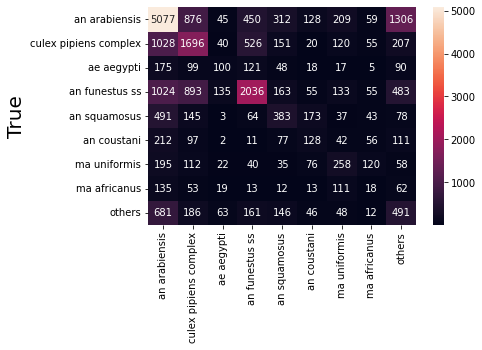

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 18batch = 0 of 3391duraation = 0.019228788216908772
epoch = 18batch = 200 of 3391duraation = 1.351532757282257
epoch = 18batch = 400 of 3391duraation = 2.678304882844289
epoch = 18batch = 600 of 3391duraation = 4.001080163319906
epoch = 18batch = 800 of 3391duraation = 5.323707056045532
epoch = 18batch = 1000 of 3391duraation = 6.640444223086039
epoch = 18batch = 1200 of 3391duraation = 7.9552338520685835
epoch = 18batch = 1400 of 3391duraation = 9.279273875554402
epoch = 18batch = 1600 of 3391duraation = 10.599705108006795
epoch = 18batch = 1800 of 3391duraation = 11.922676372528077
epoch = 18batch = 2000 of 3391duraation = 13.244566150506337
epoch = 18batch = 2200 of 3391duraation = 14.57260111172994
epoch = 18batch = 2400 of 3391duraation = 15.887411948045095
epoch = 18batch = 2600 of 3391duraation = 17.210455493132272
epoch = 18batch = 2800 of 3391duraation = 18.53221703370412
epoch = 18batch = 3000 of 3391duraation = 19.850381310780843
epoch = 18batch = 3200 of 3391duraati

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 19batch = 0 of 3391duraation = 0.02225782076517741
epoch = 19batch = 200 of 3391duraation = 1.3499025225639343
epoch = 19batch = 400 of 3391duraation = 2.6701000730196633
epoch = 19batch = 600 of 3391duraation = 3.9843433141708373
epoch = 19batch = 800 of 3391duraation = 5.304392464955648
epoch = 19batch = 1000 of 3391duraation = 6.624880623817444
epoch = 19batch = 1200 of 3391duraation = 7.942918336391449
epoch = 19batch = 1400 of 3391duraation = 9.25839376449585
epoch = 19batch = 1600 of 3391duraation = 10.57868525981903
epoch = 19batch = 1800 of 3391duraation = 11.90030090411504
epoch = 19batch = 2000 of 3391duraation = 13.22123859723409
epoch = 19batch = 2200 of 3391duraation = 14.53783739010493
epoch = 19batch = 2400 of 3391duraation = 15.858759677410125
epoch = 19batch = 2600 of 3391duraation = 17.181352388858794
epoch = 19batch = 2800 of 3391duraation = 18.503562005360923
epoch = 19batch = 3000 of 3391duraation = 19.833450428644817
epoch = 19batch = 3200 of 3391duraation

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 20batch = 0 of 3391duraation = 0.020823272069295247
epoch = 20batch = 200 of 3391duraation = 1.3443506558736165
epoch = 20batch = 400 of 3391duraation = 2.6522993087768554
epoch = 20batch = 600 of 3391duraation = 3.970179768403371
epoch = 20batch = 800 of 3391duraation = 5.2925734122594195
epoch = 20batch = 1000 of 3391duraation = 6.613520789146423
epoch = 20batch = 1200 of 3391duraation = 7.944809846083323
epoch = 20batch = 1400 of 3391duraation = 9.257893792788188
epoch = 20batch = 1600 of 3391duraation = 10.583338248729707
epoch = 20batch = 1800 of 3391duraation = 11.911045551300049
epoch = 20batch = 2000 of 3391duraation = 13.237743826707204
epoch = 20batch = 2200 of 3391duraation = 14.561843792597452
epoch = 20batch = 2400 of 3391duraation = 15.887888137499491
epoch = 20batch = 2600 of 3391duraation = 17.20328611532847
epoch = 20batch = 2800 of 3391duraation = 18.526922221978506
epoch = 20batch = 3000 of 3391duraation = 19.856989534695945
epoch = 20batch = 3200 of 3391dura

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 21batch = 0 of 3391duraation = 0.018011033535003662
epoch = 21batch = 200 of 3391duraation = 1.357508111000061
epoch = 21batch = 400 of 3391duraation = 2.6695281585057575
epoch = 21batch = 600 of 3391duraation = 3.9894281109174092
epoch = 21batch = 800 of 3391duraation = 5.315185431639353
epoch = 21batch = 1000 of 3391duraation = 6.631077734629313
epoch = 21batch = 1200 of 3391duraation = 7.947742728392283
epoch = 21batch = 1400 of 3391duraation = 9.263760189215342
epoch = 21batch = 1600 of 3391duraation = 10.589797166983287
epoch = 21batch = 1800 of 3391duraation = 11.912098224957784
epoch = 21batch = 2000 of 3391duraation = 13.237240636348725
epoch = 21batch = 2200 of 3391duraation = 14.561816636721293
epoch = 21batch = 2400 of 3391duraation = 15.879760166009268
epoch = 21batch = 2600 of 3391duraation = 17.202454014619192
epoch = 21batch = 2800 of 3391duraation = 18.52888286113739
epoch = 21batch = 3000 of 3391duraation = 19.842196381092073
epoch = 21batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 22batch = 0 of 3391duraation = 0.017587363719940186
epoch = 22batch = 200 of 3391duraation = 1.3442020018895466
epoch = 22batch = 400 of 3391duraation = 2.653081703186035
epoch = 22batch = 600 of 3391duraation = 3.9654876073201497
epoch = 22batch = 800 of 3391duraation = 5.284761242071787
epoch = 22batch = 1000 of 3391duraation = 6.592245272795359
epoch = 22batch = 1200 of 3391duraation = 7.912215928236644
epoch = 22batch = 1400 of 3391duraation = 9.222780732313792
epoch = 22batch = 1600 of 3391duraation = 10.538306128978729
epoch = 22batch = 1800 of 3391duraation = 11.859860002994537
epoch = 22batch = 2000 of 3391duraation = 13.175235589345297
epoch = 22batch = 2200 of 3391duraation = 14.48992744286855
epoch = 22batch = 2400 of 3391duraation = 15.800692788759868
epoch = 22batch = 2600 of 3391duraation = 17.12247002919515
epoch = 22batch = 2800 of 3391duraation = 18.438481076558432
epoch = 22batch = 3000 of 3391duraation = 19.759444522857667
epoch = 22batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 23batch = 0 of 3391duraation = 0.018432140350341797
epoch = 23batch = 200 of 3391duraation = 1.3360699772834779
epoch = 23batch = 400 of 3391duraation = 2.6520676493644713
epoch = 23batch = 600 of 3391duraation = 3.9674116730690003
epoch = 23batch = 800 of 3391duraation = 5.283851059277852
epoch = 23batch = 1000 of 3391duraation = 6.594232789675394
epoch = 23batch = 1200 of 3391duraation = 7.9087083299954735
epoch = 23batch = 1400 of 3391duraation = 9.223570843537649
epoch = 23batch = 1600 of 3391duraation = 10.538357237974802
epoch = 23batch = 1800 of 3391duraation = 11.85177819331487
epoch = 23batch = 2000 of 3391duraation = 13.171885101000468
epoch = 23batch = 2200 of 3391duraation = 14.488308993975322
epoch = 23batch = 2400 of 3391duraation = 15.79850005308787
epoch = 23batch = 2600 of 3391duraation = 17.11436883211136
epoch = 23batch = 2800 of 3391duraation = 18.43228132724762
epoch = 23batch = 3000 of 3391duraation = 19.74888206720352
epoch = 23batch = 3200 of 3391duraati

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 24batch = 0 of 3391duraation = 0.017996052900950115
epoch = 24batch = 200 of 3391duraation = 1.3370208382606505
epoch = 24batch = 400 of 3391duraation = 2.6426311055819194
epoch = 24batch = 600 of 3391duraation = 3.9566619277000425
epoch = 24batch = 800 of 3391duraation = 5.269461027781168
epoch = 24batch = 1000 of 3391duraation = 6.578255546092987
epoch = 24batch = 1200 of 3391duraation = 7.883916572729746
epoch = 24batch = 1400 of 3391duraation = 9.192434481779735
epoch = 24batch = 1600 of 3391duraation = 10.50467673142751
epoch = 24batch = 1800 of 3391duraation = 11.820385110378265
epoch = 24batch = 2000 of 3391duraation = 13.134430185953777
epoch = 24batch = 2200 of 3391duraation = 14.448965009053548
epoch = 24batch = 2400 of 3391duraation = 15.760797154903411
epoch = 24batch = 2600 of 3391duraation = 17.07147568464279
epoch = 24batch = 2800 of 3391duraation = 18.389285385608673
epoch = 24batch = 3000 of 3391duraation = 19.699644680817922
epoch = 24batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 25batch = 0 of 3391duraation = 0.020182148615519205
epoch = 25batch = 200 of 3391duraation = 1.3468800067901612
epoch = 25batch = 400 of 3391duraation = 2.652387571334839
epoch = 25batch = 600 of 3391duraation = 3.961381769180298
epoch = 25batch = 800 of 3391duraation = 5.280789959430694
epoch = 25batch = 1000 of 3391duraation = 6.591708250840505
epoch = 25batch = 1200 of 3391duraation = 7.894811801115671
epoch = 25batch = 1400 of 3391duraation = 9.206322582562764
epoch = 25batch = 1600 of 3391duraation = 10.517693308989207
epoch = 25batch = 1800 of 3391duraation = 11.830201947689057
epoch = 25batch = 2000 of 3391duraation = 13.134904352823893
epoch = 25batch = 2200 of 3391duraation = 14.448954745133717
epoch = 25batch = 2400 of 3391duraation = 15.763822599252064
epoch = 25batch = 2600 of 3391duraation = 17.071423125267028
epoch = 25batch = 2800 of 3391duraation = 18.378115741411843
epoch = 25batch = 3000 of 3391duraation = 19.686066929499308
epoch = 25batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 26batch = 0 of 3391duraation = 0.021782906850179036
epoch = 26batch = 200 of 3391duraation = 1.3406304359436034
epoch = 26batch = 400 of 3391duraation = 2.6546351154645285
epoch = 26batch = 600 of 3391duraation = 3.962646810213725
epoch = 26batch = 800 of 3391duraation = 5.276795903841655
epoch = 26batch = 1000 of 3391duraation = 6.590798195203146
epoch = 26batch = 1200 of 3391duraation = 7.893871597448984
epoch = 26batch = 1400 of 3391duraation = 9.204928847153981
epoch = 26batch = 1600 of 3391duraation = 10.51266215244929
epoch = 26batch = 1800 of 3391duraation = 11.833859546979268
epoch = 26batch = 2000 of 3391duraation = 13.136118892828623
epoch = 26batch = 2200 of 3391duraation = 14.452861162026723
epoch = 26batch = 2400 of 3391duraation = 15.750724518299103
epoch = 26batch = 2600 of 3391duraation = 17.061827206611632
epoch = 26batch = 2800 of 3391duraation = 18.368173865477242
epoch = 26batch = 3000 of 3391duraation = 19.678242909908295
epoch = 26batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 27batch = 0 of 3391duraation = 0.021383158365885415
epoch = 27batch = 200 of 3391duraation = 1.34098828236262
epoch = 27batch = 400 of 3391duraation = 2.656321318944295
epoch = 27batch = 600 of 3391duraation = 3.962814784049988
epoch = 27batch = 800 of 3391duraation = 5.2776790420214335
epoch = 27batch = 1000 of 3391duraation = 6.588236113389333
epoch = 27batch = 1200 of 3391duraation = 7.896266861756643
epoch = 27batch = 1400 of 3391duraation = 9.208606859048208
epoch = 27batch = 1600 of 3391duraation = 10.51156727472941
epoch = 27batch = 1800 of 3391duraation = 11.832499861717224
epoch = 27batch = 2000 of 3391duraation = 13.136629966894786
epoch = 27batch = 2200 of 3391duraation = 14.435795577367147
epoch = 27batch = 2400 of 3391duraation = 15.744566853841146
epoch = 27batch = 2600 of 3391duraation = 17.054652714729308
epoch = 27batch = 2800 of 3391duraation = 18.367028776804606
epoch = 27batch = 3000 of 3391duraation = 19.67890022993088
epoch = 27batch = 3200 of 3391duraatio

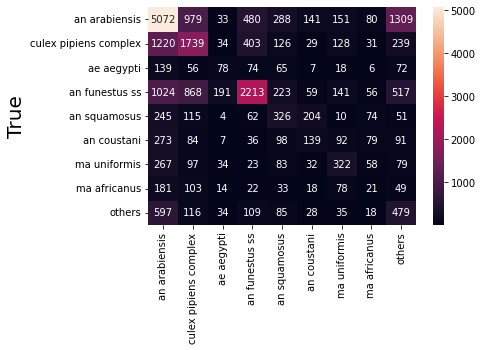

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 28batch = 0 of 3391duraation = 0.017153835296630858
epoch = 28batch = 200 of 3391duraation = 1.336313505967458
epoch = 28batch = 400 of 3391duraation = 2.6499536911646526
epoch = 28batch = 600 of 3391duraation = 3.959761639436086
epoch = 28batch = 800 of 3391duraation = 5.268227712313334
epoch = 28batch = 1000 of 3391duraation = 6.571624302864075
epoch = 28batch = 1200 of 3391duraation = 7.872846531867981
epoch = 28batch = 1400 of 3391duraation = 9.190233862400055
epoch = 28batch = 1600 of 3391duraation = 10.504179533322652
epoch = 28batch = 1800 of 3391duraation = 11.814451062679291
epoch = 28batch = 2000 of 3391duraation = 13.123044164975484
epoch = 28batch = 2200 of 3391duraation = 14.433567440509796
epoch = 28batch = 2400 of 3391duraation = 15.737761708100637
epoch = 28batch = 2600 of 3391duraation = 17.055536969502768
epoch = 28batch = 2800 of 3391duraation = 18.37612498998642
epoch = 28batch = 3000 of 3391duraation = 19.682196048895516
epoch = 28batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 29batch = 0 of 3391duraation = 0.018793682257334392
epoch = 29batch = 200 of 3391duraation = 1.3363945484161377
epoch = 29batch = 400 of 3391duraation = 2.6523178617159524
epoch = 29batch = 600 of 3391duraation = 3.965217653910319
epoch = 29batch = 800 of 3391duraation = 5.281411472956339
epoch = 29batch = 1000 of 3391duraation = 6.594361472129822
epoch = 29batch = 1200 of 3391duraation = 7.9020692110061646
epoch = 29batch = 1400 of 3391duraation = 9.21420218149821
epoch = 29batch = 1600 of 3391duraation = 10.5271253267924
epoch = 29batch = 1800 of 3391duraation = 11.836808971563975
epoch = 29batch = 2000 of 3391duraation = 13.149626684188842
epoch = 29batch = 2200 of 3391duraation = 14.46324714422226
epoch = 29batch = 2400 of 3391duraation = 15.772155805428822
epoch = 29batch = 2600 of 3391duraation = 17.08218342065811
epoch = 29batch = 2800 of 3391duraation = 18.39882619778315
epoch = 29batch = 3000 of 3391duraation = 19.720311164855957
epoch = 29batch = 3200 of 3391duraation

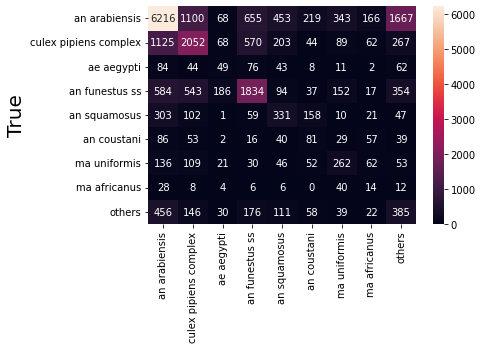

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 30batch = 0 of 3391duraation = 0.01698346932729085
epoch = 30batch = 200 of 3391duraation = 1.3454633514086405
epoch = 30batch = 400 of 3391duraation = 2.6530897339185078
epoch = 30batch = 600 of 3391duraation = 3.9646632432937623
epoch = 30batch = 800 of 3391duraation = 5.269556578000387
epoch = 30batch = 1000 of 3391duraation = 6.586556653181712
epoch = 30batch = 1200 of 3391duraation = 7.898457197348277
epoch = 30batch = 1400 of 3391duraation = 9.207495013872782
epoch = 30batch = 1600 of 3391duraation = 10.51116617123286
epoch = 30batch = 1800 of 3391duraation = 11.816346553961436
epoch = 30batch = 2000 of 3391duraation = 13.12722411553065
epoch = 30batch = 2200 of 3391duraation = 14.448035736878714
epoch = 30batch = 2400 of 3391duraation = 15.755226079622904
epoch = 30batch = 2600 of 3391duraation = 17.0634588042895
epoch = 30batch = 2800 of 3391duraation = 18.383140067259472
epoch = 30batch = 3000 of 3391duraation = 19.69452432394028
epoch = 30batch = 3200 of 3391duraation

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 31batch = 0 of 3391duraation = 0.019270058472951254
epoch = 31batch = 200 of 3391duraation = 1.342860738436381
epoch = 31batch = 400 of 3391duraation = 2.668654505411784
epoch = 31batch = 600 of 3391duraation = 3.9819676836331683
epoch = 31batch = 800 of 3391duraation = 5.302530221144358
epoch = 31batch = 1000 of 3391duraation = 6.626380276679993
epoch = 31batch = 1200 of 3391duraation = 7.948194301128387
epoch = 31batch = 1400 of 3391duraation = 9.263705571492514
epoch = 31batch = 1600 of 3391duraation = 10.586991794904073
epoch = 31batch = 1800 of 3391duraation = 11.89623794555664
epoch = 31batch = 2000 of 3391duraation = 13.21052395105362
epoch = 31batch = 2200 of 3391duraation = 14.516166353225708
epoch = 31batch = 2400 of 3391duraation = 15.836083873112996
epoch = 31batch = 2600 of 3391duraation = 17.15424752632777
epoch = 31batch = 2800 of 3391duraation = 18.467666474978127
epoch = 31batch = 3000 of 3391duraation = 19.78702449798584
epoch = 31batch = 3200 of 3391duraation

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 32batch = 0 of 3391duraation = 0.017432765165964762
epoch = 32batch = 200 of 3391duraation = 1.3371495127677917
epoch = 32batch = 400 of 3391duraation = 2.6377049922943114
epoch = 32batch = 600 of 3391duraation = 3.9462570865948994
epoch = 32batch = 800 of 3391duraation = 5.259599121411641
epoch = 32batch = 1000 of 3391duraation = 6.572078275680542
epoch = 32batch = 1200 of 3391duraation = 7.882982869942983
epoch = 32batch = 1400 of 3391duraation = 9.200577274958293
epoch = 32batch = 1600 of 3391duraation = 10.508026452859243
epoch = 32batch = 1800 of 3391duraation = 11.821098983287811
epoch = 32batch = 2000 of 3391duraation = 13.132871985435486
epoch = 32batch = 2200 of 3391duraation = 14.438823278745016
epoch = 32batch = 2400 of 3391duraation = 15.751385847727457
epoch = 32batch = 2600 of 3391duraation = 17.064948936303455
epoch = 32batch = 2800 of 3391duraation = 18.38540564775467
epoch = 32batch = 3000 of 3391duraation = 19.696224975585938
epoch = 32batch = 3200 of 3391dura

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 33batch = 0 of 3391duraation = 0.02061307430267334
epoch = 33batch = 200 of 3391duraation = 1.3385421991348267
epoch = 33batch = 400 of 3391duraation = 2.653082724412282
epoch = 33batch = 600 of 3391duraation = 3.962100152174632
epoch = 33batch = 800 of 3391duraation = 5.26911438703537
epoch = 33batch = 1000 of 3391duraation = 6.582278442382813
epoch = 33batch = 1200 of 3391duraation = 7.8968800663948056
epoch = 33batch = 1400 of 3391duraation = 9.20913705031077
epoch = 33batch = 1600 of 3391duraation = 10.51680783033371
epoch = 33batch = 1800 of 3391duraation = 11.828445482254029
epoch = 33batch = 2000 of 3391duraation = 13.136879030863444
epoch = 33batch = 2200 of 3391duraation = 14.450240238507588
epoch = 33batch = 2400 of 3391duraation = 15.761506001154581
epoch = 33batch = 2600 of 3391duraation = 17.0741734623909
epoch = 33batch = 2800 of 3391duraation = 18.38156133890152
epoch = 33batch = 3000 of 3391duraation = 19.691945481300355
epoch = 33batch = 3200 of 3391duraation =

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 34batch = 0 of 3391duraation = 0.020495661099751792
epoch = 34batch = 200 of 3391duraation = 1.350246798992157
epoch = 34batch = 400 of 3391duraation = 2.674503231048584
epoch = 34batch = 600 of 3391duraation = 3.9968020717302957
epoch = 34batch = 800 of 3391duraation = 5.314384631315867
epoch = 34batch = 1000 of 3391duraation = 6.632573397954305
epoch = 34batch = 1200 of 3391duraation = 7.933481804529825
epoch = 34batch = 1400 of 3391duraation = 9.245736928780873
epoch = 34batch = 1600 of 3391duraation = 10.554973542690277
epoch = 34batch = 1800 of 3391duraation = 11.87411554257075
epoch = 34batch = 2000 of 3391duraation = 13.190632569789887
epoch = 34batch = 2200 of 3391duraation = 14.506570021311441
epoch = 34batch = 2400 of 3391duraation = 15.830673531691234
epoch = 34batch = 2600 of 3391duraation = 17.14774344364802
epoch = 34batch = 2800 of 3391duraation = 18.458616948127748
epoch = 34batch = 3000 of 3391duraation = 19.777120765050253
epoch = 34batch = 3200 of 3391duraati

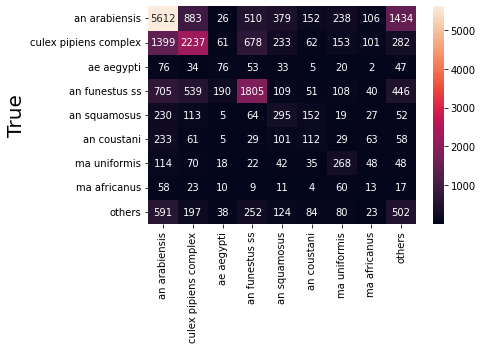

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 35batch = 0 of 3391duraation = 0.020349641640981037
epoch = 35batch = 200 of 3391duraation = 1.3363770882288615
epoch = 35batch = 400 of 3391duraation = 2.648007321357727
epoch = 35batch = 600 of 3391duraation = 3.9731269001960756
epoch = 35batch = 800 of 3391duraation = 5.287127208709717
epoch = 35batch = 1000 of 3391duraation = 6.603744351863861
epoch = 35batch = 1200 of 3391duraation = 7.910161725680033
epoch = 35batch = 1400 of 3391duraation = 9.226012110710144
epoch = 35batch = 1600 of 3391duraation = 10.536581556002298
epoch = 35batch = 1800 of 3391duraation = 11.836341611544292
epoch = 35batch = 2000 of 3391duraation = 13.145513427257537
epoch = 35batch = 2200 of 3391duraation = 14.46157701810201
epoch = 35batch = 2400 of 3391duraation = 15.772712075710297
epoch = 35batch = 2600 of 3391duraation = 17.08870008389155
epoch = 35batch = 2800 of 3391duraation = 18.403529699643453
epoch = 35batch = 3000 of 3391duraation = 19.716112740834554
epoch = 35batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 36batch = 0 of 3391duraation = 0.020021661122639974
epoch = 36batch = 200 of 3391duraation = 1.3415036082267762
epoch = 36batch = 400 of 3391duraation = 2.656197452545166
epoch = 36batch = 600 of 3391duraation = 3.9649550040562946
epoch = 36batch = 800 of 3391duraation = 5.268119116624196
epoch = 36batch = 1000 of 3391duraation = 6.576526033878326
epoch = 36batch = 1200 of 3391duraation = 7.879098339875539
epoch = 36batch = 1400 of 3391duraation = 9.184733513991038
epoch = 36batch = 1600 of 3391duraation = 10.498968124389648
epoch = 36batch = 1800 of 3391duraation = 11.80578755537669
epoch = 36batch = 2000 of 3391duraation = 13.128417364756267
epoch = 36batch = 2200 of 3391duraation = 14.432603085041046
epoch = 36batch = 2400 of 3391duraation = 15.75236603418986
epoch = 36batch = 2600 of 3391duraation = 17.05891050895055
epoch = 36batch = 2800 of 3391duraation = 18.372383709748586
epoch = 36batch = 3000 of 3391duraation = 19.690237124760944
epoch = 36batch = 3200 of 3391duraati

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 37batch = 0 of 3391duraation = 0.021326100826263426
epoch = 37batch = 200 of 3391duraation = 1.3383440534273783
epoch = 37batch = 400 of 3391duraation = 2.647217313448588
epoch = 37batch = 600 of 3391duraation = 3.960005211830139
epoch = 37batch = 800 of 3391duraation = 5.262206236521403
epoch = 37batch = 1000 of 3391duraation = 6.575727947552999
epoch = 37batch = 1200 of 3391duraation = 7.88472498257955
epoch = 37batch = 1400 of 3391duraation = 9.192937401930491
epoch = 37batch = 1600 of 3391duraation = 10.509629718462627
epoch = 37batch = 1800 of 3391duraation = 11.829428327083587
epoch = 37batch = 2000 of 3391duraation = 13.136936251322428
epoch = 37batch = 2200 of 3391duraation = 14.455846826235453
epoch = 37batch = 2400 of 3391duraation = 15.774845429261525
epoch = 37batch = 2600 of 3391duraation = 17.087326482931772
epoch = 37batch = 2800 of 3391duraation = 18.40212970972061
epoch = 37batch = 3000 of 3391duraation = 19.718206981817882
epoch = 37batch = 3200 of 3391duraati

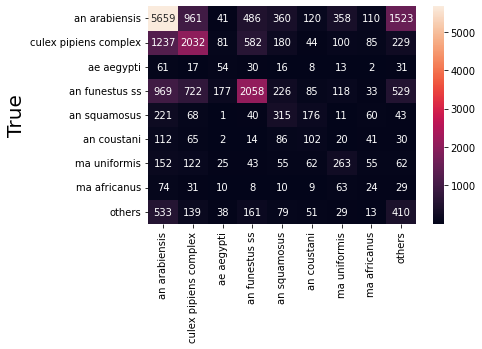

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 38batch = 0 of 3391duraation = 0.019310112794240317
epoch = 38batch = 200 of 3391duraation = 1.3423013726870219
epoch = 38batch = 400 of 3391duraation = 2.6523468097050986
epoch = 38batch = 600 of 3391duraation = 3.968906843662262
epoch = 38batch = 800 of 3391duraation = 5.2861506819725035
epoch = 38batch = 1000 of 3391duraation = 6.595063575108846
epoch = 38batch = 1200 of 3391duraation = 7.916760575771332
epoch = 38batch = 1400 of 3391duraation = 9.231050658226014
epoch = 38batch = 1600 of 3391duraation = 10.542572128772736
epoch = 38batch = 1800 of 3391duraation = 11.853556283315022
epoch = 38batch = 2000 of 3391duraation = 13.173112241427104
epoch = 38batch = 2200 of 3391duraation = 14.489358190695445
epoch = 38batch = 2400 of 3391duraation = 15.802233306566874
epoch = 38batch = 2600 of 3391duraation = 17.123862409591673
epoch = 38batch = 2800 of 3391duraation = 18.435950406392415
epoch = 38batch = 3000 of 3391duraation = 19.746915551026664
epoch = 38batch = 3200 of 3391dur

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 39batch = 0 of 3391duraation = 0.01706240971883138
epoch = 39batch = 200 of 3391duraation = 1.3412139256795248
epoch = 39batch = 400 of 3391duraation = 2.6623576203982036
epoch = 39batch = 600 of 3391duraation = 3.970016686121623
epoch = 39batch = 800 of 3391duraation = 5.279332466920217
epoch = 39batch = 1000 of 3391duraation = 6.592590888341268
epoch = 39batch = 1200 of 3391duraation = 7.910642755031586
epoch = 39batch = 1400 of 3391duraation = 9.21841117143631
epoch = 39batch = 1600 of 3391duraation = 10.531848653157551
epoch = 39batch = 1800 of 3391duraation = 11.84354590177536
epoch = 39batch = 2000 of 3391duraation = 13.143212342262268
epoch = 39batch = 2200 of 3391duraation = 14.453211390972138
epoch = 39batch = 2400 of 3391duraation = 15.76925802230835
epoch = 39batch = 2600 of 3391duraation = 17.08310311237971
epoch = 39batch = 2800 of 3391duraation = 18.39778818686803
epoch = 39batch = 3000 of 3391duraation = 19.708547818660737
epoch = 39batch = 3200 of 3391duraation 

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 40batch = 0 of 3391duraation = 0.02015519142150879
epoch = 40batch = 200 of 3391duraation = 1.329958681265513
epoch = 40batch = 400 of 3391duraation = 2.6508485873540244
epoch = 40batch = 600 of 3391duraation = 3.9517326792081198
epoch = 40batch = 800 of 3391duraation = 5.2707313895225525
epoch = 40batch = 1000 of 3391duraation = 6.580933511257172
epoch = 40batch = 1200 of 3391duraation = 7.886603113015493
epoch = 40batch = 1400 of 3391duraation = 9.195297420024872
epoch = 40batch = 1600 of 3391duraation = 10.515006279945373
epoch = 40batch = 1800 of 3391duraation = 11.820897241433462
epoch = 40batch = 2000 of 3391duraation = 13.129023738702138
epoch = 40batch = 2200 of 3391duraation = 14.442597579956054
epoch = 40batch = 2400 of 3391duraation = 15.753781712055206
epoch = 40batch = 2600 of 3391duraation = 17.067759211858114
epoch = 40batch = 2800 of 3391duraation = 18.377325320243834
epoch = 40batch = 3000 of 3391duraation = 19.697134371598562
epoch = 40batch = 3200 of 3391dura

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 41batch = 0 of 3391duraation = 0.020337692896525063
epoch = 41batch = 200 of 3391duraation = 1.3381693641344705
epoch = 41batch = 400 of 3391duraation = 2.643509785334269
epoch = 41batch = 600 of 3391duraation = 3.9549068450927733
epoch = 41batch = 800 of 3391duraation = 5.2693689902623495
epoch = 41batch = 1000 of 3391duraation = 6.579104741414388
epoch = 41batch = 1200 of 3391duraation = 7.891017063458761
epoch = 41batch = 1400 of 3391duraation = 9.20058878660202
epoch = 41batch = 1600 of 3391duraation = 10.503325815995534
epoch = 41batch = 1800 of 3391duraation = 11.821106127897899
epoch = 41batch = 2000 of 3391duraation = 13.133753263950348
epoch = 41batch = 2200 of 3391duraation = 14.446497150262196
epoch = 41batch = 2400 of 3391duraation = 15.757113599777222
epoch = 41batch = 2600 of 3391duraation = 17.076960949103036
epoch = 41batch = 2800 of 3391duraation = 18.385096402963004
epoch = 41batch = 3000 of 3391duraation = 19.696623210112254
epoch = 41batch = 3200 of 3391dura

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 42batch = 0 of 3391duraation = 0.017354206244150797
epoch = 42batch = 200 of 3391duraation = 1.3397425969441732
epoch = 42batch = 400 of 3391duraation = 2.6542336543401084
epoch = 42batch = 600 of 3391duraation = 3.967581323782603
epoch = 42batch = 800 of 3391duraation = 5.277375113964081
epoch = 42batch = 1000 of 3391duraation = 6.590421275297801
epoch = 42batch = 1200 of 3391duraation = 7.902028274536133
epoch = 42batch = 1400 of 3391duraation = 9.213147421677908
epoch = 42batch = 1600 of 3391duraation = 10.528574689229329
epoch = 42batch = 1800 of 3391duraation = 11.839296631018321
epoch = 42batch = 2000 of 3391duraation = 13.153517007827759
epoch = 42batch = 2200 of 3391duraation = 14.475666320323944
epoch = 42batch = 2400 of 3391duraation = 15.785335795084636
epoch = 42batch = 2600 of 3391duraation = 17.10478085676829
epoch = 42batch = 2800 of 3391duraation = 18.422760208447773
epoch = 42batch = 3000 of 3391duraation = 19.734894466400146
epoch = 42batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 43batch = 0 of 3391duraation = 0.018066044648488364
epoch = 43batch = 200 of 3391duraation = 1.336353317896525
epoch = 43batch = 400 of 3391duraation = 2.645050013065338
epoch = 43batch = 600 of 3391duraation = 3.9532789667447408
epoch = 43batch = 800 of 3391duraation = 5.270689300696055
epoch = 43batch = 1000 of 3391duraation = 6.5822275956471765
epoch = 43batch = 1200 of 3391duraation = 7.892589970429738
epoch = 43batch = 1400 of 3391duraation = 9.208769488334656
epoch = 43batch = 1600 of 3391duraation = 10.520838979880015
epoch = 43batch = 1800 of 3391duraation = 11.833634376525879
epoch = 43batch = 2000 of 3391duraation = 13.14974156220754
epoch = 43batch = 2200 of 3391duraation = 14.463721923033397
epoch = 43batch = 2400 of 3391duraation = 15.781962033112844
epoch = 43batch = 2600 of 3391duraation = 17.09505758682887
epoch = 43batch = 2800 of 3391duraation = 18.40998451312383
epoch = 43batch = 3000 of 3391duraation = 19.72572958866755
epoch = 43batch = 3200 of 3391duraatio

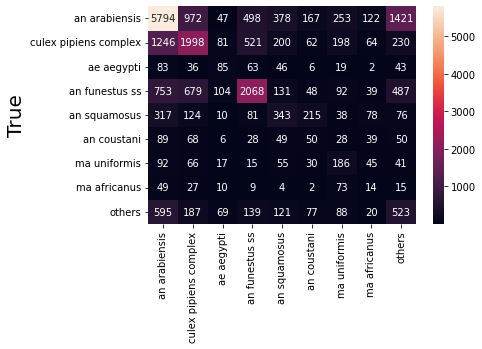

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 44batch = 0 of 3391duraation = 0.018691007296244302
epoch = 44batch = 200 of 3391duraation = 1.3443629264831543
epoch = 44batch = 400 of 3391duraation = 2.6585395057996113
epoch = 44batch = 600 of 3391duraation = 3.972868923346202
epoch = 44batch = 800 of 3391duraation = 5.289838067690531
epoch = 44batch = 1000 of 3391duraation = 6.612767386436462
epoch = 44batch = 1200 of 3391duraation = 7.928149855136871
epoch = 44batch = 1400 of 3391duraation = 9.241979428132375
epoch = 44batch = 1600 of 3391duraation = 10.554282649358113
epoch = 44batch = 1800 of 3391duraation = 11.875521691640218
epoch = 44batch = 2000 of 3391duraation = 13.19029791355133
epoch = 44batch = 2200 of 3391duraation = 14.506827088197072
epoch = 44batch = 2400 of 3391duraation = 15.824558063348134
epoch = 44batch = 2600 of 3391duraation = 17.134546220302582
epoch = 44batch = 2800 of 3391duraation = 18.44629381100337
epoch = 44batch = 3000 of 3391duraation = 19.759833252429964
epoch = 44batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 45batch = 0 of 3391duraation = 0.017507533232371014
epoch = 45batch = 200 of 3391duraation = 1.3448933124542237
epoch = 45batch = 400 of 3391duraation = 2.6511067668596904
epoch = 45batch = 600 of 3391duraation = 3.962039812405904
epoch = 45batch = 800 of 3391duraation = 5.2676722248395285
epoch = 45batch = 1000 of 3391duraation = 6.587660646438598
epoch = 45batch = 1200 of 3391duraation = 7.904073623816172
epoch = 45batch = 1400 of 3391duraation = 9.207988619804382
epoch = 45batch = 1600 of 3391duraation = 10.516090941429137
epoch = 45batch = 1800 of 3391duraation = 11.821094469229381
epoch = 45batch = 2000 of 3391duraation = 13.132260835170745
epoch = 45batch = 2200 of 3391duraation = 14.450930412610372
epoch = 45batch = 2400 of 3391duraation = 15.766212940216064
epoch = 45batch = 2600 of 3391duraation = 17.080828217665353
epoch = 45batch = 2800 of 3391duraation = 18.38913502693176
epoch = 45batch = 3000 of 3391duraation = 19.70876375436783
epoch = 45batch = 3200 of 3391duraa

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 46batch = 0 of 3391duraation = 0.017596113681793212
epoch = 46batch = 200 of 3391duraation = 1.338105054696401
epoch = 46batch = 400 of 3391duraation = 2.654993212223053
epoch = 46batch = 600 of 3391duraation = 3.9574758648872375
epoch = 46batch = 800 of 3391duraation = 5.258820990721385
epoch = 46batch = 1000 of 3391duraation = 6.570383659998575
epoch = 46batch = 1200 of 3391duraation = 7.880824108918508
epoch = 46batch = 1400 of 3391duraation = 9.188253863652546
epoch = 46batch = 1600 of 3391duraation = 10.489827573299408
epoch = 46batch = 1800 of 3391duraation = 11.808554828166962
epoch = 46batch = 2000 of 3391duraation = 13.118498714764913
epoch = 46batch = 2200 of 3391duraation = 14.436022516091665
epoch = 46batch = 2400 of 3391duraation = 15.752681410312652
epoch = 46batch = 2600 of 3391duraation = 17.062832097212475
epoch = 46batch = 2800 of 3391duraation = 18.371558403968812
epoch = 46batch = 3000 of 3391duraation = 19.69150237639745
epoch = 46batch = 3200 of 3391duraat

  0%|          | 0/3391 [00:00<?, ?it/s]

epoch = 47batch = 0 of 3391duraation = 0.021207300821940105
epoch = 47batch = 200 of 3391duraation = 1.339875594774882
epoch = 47batch = 400 of 3391duraation = 2.652374565601349
epoch = 47batch = 600 of 3391duraation = 3.9573700626691184
epoch = 47batch = 800 of 3391duraation = 5.264761261145273
epoch = 47batch = 1000 of 3391duraation = 6.5783776839574175
epoch = 47batch = 1200 of 3391duraation = 7.890393408139547
epoch = 47batch = 1400 of 3391duraation = 9.19637446006139
epoch = 47batch = 1600 of 3391duraation = 10.50661414861679
epoch = 47batch = 1800 of 3391duraation = 11.820773847897847
epoch = 47batch = 2000 of 3391duraation = 13.132524176438649
epoch = 47batch = 2200 of 3391duraation = 14.438646725813548
epoch = 47batch = 2400 of 3391duraation = 15.75735118786494
epoch = 47batch = 2600 of 3391duraation = 17.065659495194755
epoch = 47batch = 2800 of 3391duraation = 18.378851906458536
epoch = 47batch = 3000 of 3391duraation = 19.689282524585725
epoch = 47batch = 3200 of 3391duraati

In [ ]:
model =Model('convnext_small',224)

model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))